In [1]:
import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers, layers

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
    
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

REPLICAS: 1
2.6.3


In [2]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 75
BATCH_SIZE = 1

print(tf.__version__)

2.6.3


In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')

fn_monet = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet Files:', len(fn_monet))

fn_photo = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo Files:', len(fn_photo))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(fn_monet)
n_photo_samples = count_data_items(fn_photo)

print(f'Monet TFRecord files: {len(fn_monet)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(fn_photo)}')
print(f'Photo image files: {n_photo_samples}')

2022-05-13 06:33:59.766093: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Monet Files: 5
Photo Files: 20
Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038


In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.21)
])

2022-05-13 06:34:00.655320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 06:34:00.778233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 06:34:00.778967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 06:34:00.780190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
IMAGE_SIZE = [256,256]

In [6]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

**Loading Dataset**

In [8]:
def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):
    monet_ds = load_dataset(fn_monet)
    photo_ds = load_dataset(fn_photo)
    
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
   
    if augment: 
        monet_ds = monet_ds.map(augment, AUTOTUNE)
        photo_ds = photo_ds.map(augment, AUTOTUNE)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
        
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()
    
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

**Visualization of the example of both types of the images**

The encoder model here is U-Net architecture with down sampling and up sampling modules. 

In down sampling the dimensions of the images are reduced so:
1. it makes the data of a more manageable size
2. reduces the dimensionality of the data thus enabling in faster processing of the data (image)
3. reducing the storage size of the data

In upsampling the dimensions of the images are increased as number of rows ad columns are added.

# **Creating Generator and Discriminator Model**

In [9]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

2022-05-13 06:34:04.065841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


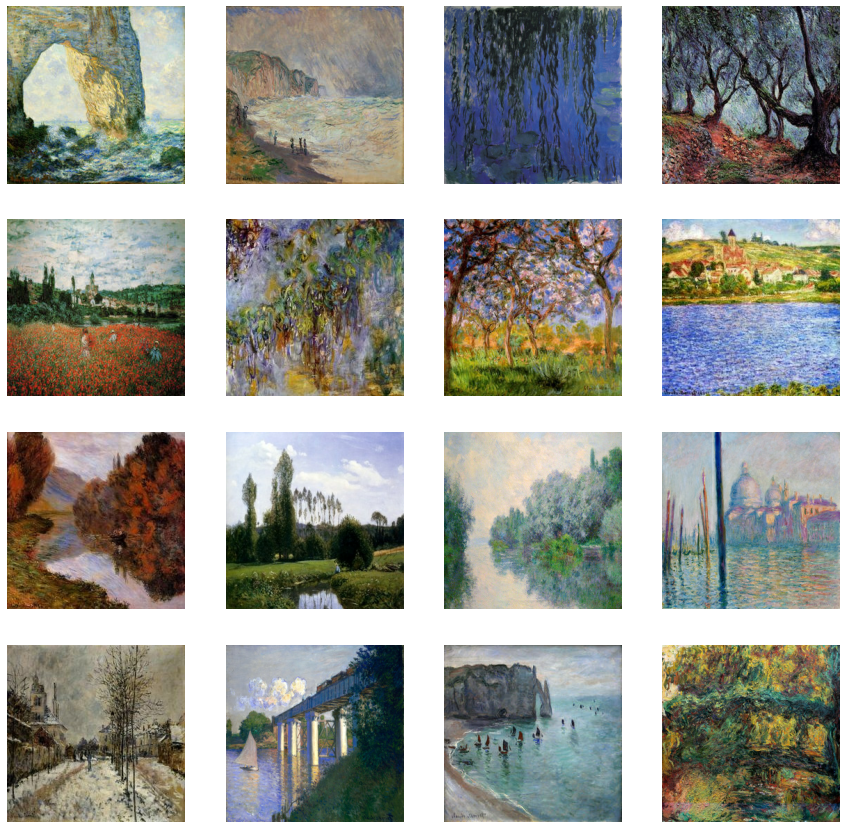

In [11]:
display_samples(load_dataset(fn_monet).batch(15), 4, 4)

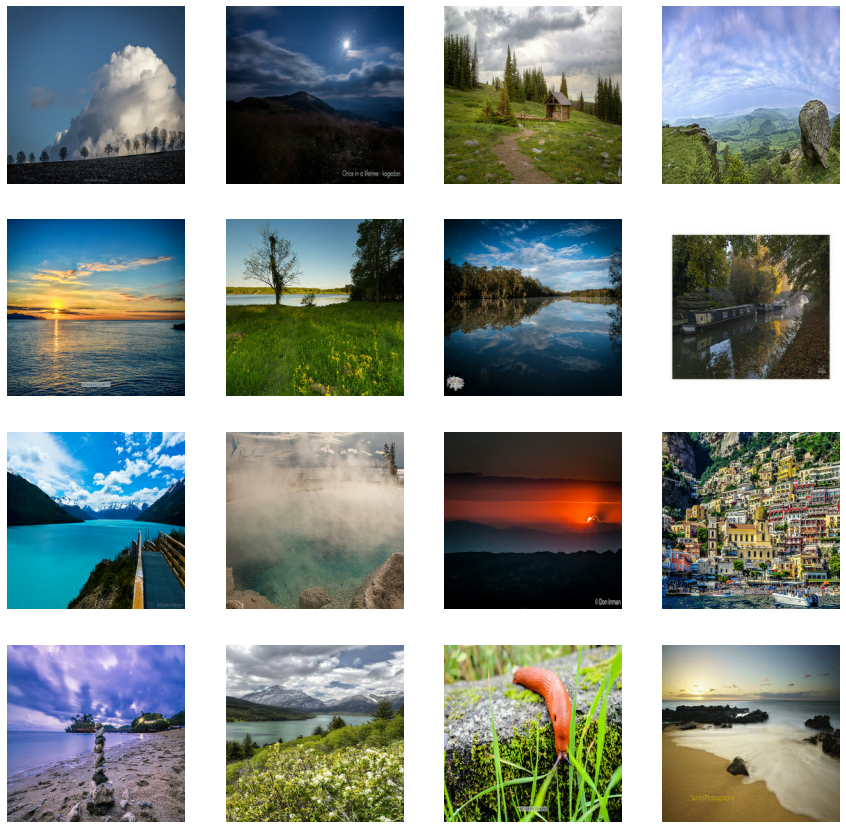

In [12]:
display_samples(load_dataset(fn_photo).batch(15), 4, 4)

# **1. Generator Model**

In [13]:
def Generator():
    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64) 256/2（padding same，(256-4+1)/2）
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024) 1*2（padding same，(1*2-4+1)），，
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh') # (bs, 256, 256, 3)，，

    x = inputs

    # downsampling the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# **2. Discriminator Model**

In [14]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)，，

    return tf.keras.Model(inputs=inp, outputs=last)

Got the idea from: https://github.com/GANs-in-Action/gans-in-action/blob/master/chapter-3/Chapter_3_GAN.ipynb

In [15]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
    
    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)#G(x)
            cycled_photo = self.p_gen(fake_monet, training=True)#F(G(x))

            fake_photo = self.p_gen(real_monet, training=True)#F(y)
            cycled_monet = self.m_gen(fake_photo, training=True)#G(F(y))

            same_monet = self.m_gen(real_monet, training=True)#G(y)
            same_photo = self.p_gen(real_photo, training=True)#F(x)

            disc_real_monet = self.m_disc(real_monet, training=True)#DY(y)
            disc_real_photo = self.p_disc(real_photo, training=True)#DX(x)

            disc_fake_monet = self.m_disc(fake_monet, training=True)#DY(G(x))
            disc_fake_photo = self.p_disc(fake_photo, training=True)#DX(F(y))

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

       
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss,self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [17]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        
        return total_disc_loss * 0.5

In [18]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [19]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
        return LAMBDA * loss1

In [20]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        
        return LAMBDA * 0.5 * loss

In [21]:
with strategy.scope():
    monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
with strategy.scope():
    monet_generator=Generator()
    photo_generator=Generator()
    monet_discriminator=Discriminator()
    photo_discriminator=Discriminator()
with strategy.scope():
    cycle_gan_model = CycleGan(monet_generator,photo_generator,monet_discriminator,photo_discriminator)
    cycle_gan_model.compile(
            m_gen_optimizer = monet_generator_optimizer,
            p_gen_optimizer = photo_generator_optimizer,
            m_disc_optimizer = monet_discriminator_optimizer,
            p_disc_optimizer = photo_discriminator_optimizer,
            gen_loss_fn = generator_loss,
            disc_loss_fn = discriminator_loss,
            cycle_loss_fn = calc_cycle_loss,
            identity_loss_fn = identity_loss
        )
    history = cycle_gan_model.fit(get_gan_dataset(fn_monet, fn_photo, batch_size=BATCH_SIZE), 
                        steps_per_epoch=(n_monet_samples//BATCH_SIZE),
                        epochs=EPOCHS,
                        verbose=2).history

Epoch 1/75


2022-05-13 06:35:03.164963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1057 of 2048
2022-05-13 06:35:09.558241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-05-13 06:35:10.356268: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


300/300 - 122s - monet_gen_loss: 4.6825 - photo_gen_loss: 4.6701 - monet_disc_loss: 0.6672 - photo_disc_loss: 0.7024
Epoch 2/75
300/300 - 68s - monet_gen_loss: 4.2229 - photo_gen_loss: 4.2798 - monet_disc_loss: 0.7562 - photo_disc_loss: 0.6343
Epoch 3/75
300/300 - 68s - monet_gen_loss: 4.1207 - photo_gen_loss: 3.4145 - monet_disc_loss: 0.6434 - photo_disc_loss: 0.6918
Epoch 4/75
300/300 - 66s - monet_gen_loss: 3.8367 - photo_gen_loss: 3.8697 - monet_disc_loss: 0.6913 - photo_disc_loss: 0.5678
Epoch 5/75
300/300 - 65s - monet_gen_loss: 3.9796 - photo_gen_loss: 3.4299 - monet_disc_loss: 0.5550 - photo_disc_loss: 0.6070
Epoch 6/75
300/300 - 65s - monet_gen_loss: 3.9527 - photo_gen_loss: 3.2384 - monet_disc_loss: 0.6288 - photo_disc_loss: 0.5777
Epoch 7/75
300/300 - 65s - monet_gen_loss: 3.5979 - photo_gen_loss: 3.1030 - monet_disc_loss: 0.6041 - photo_disc_loss: 0.7257
Epoch 8/75
300/300 - 65s - monet_gen_loss: 3.3318 - photo_gen_loss: 2.9275 - monet_disc_loss: 0.7255 - photo_disc_loss: 0

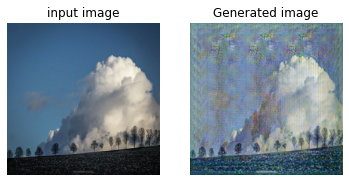

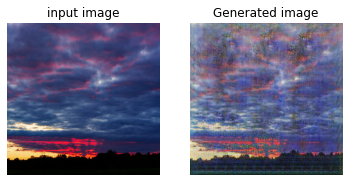

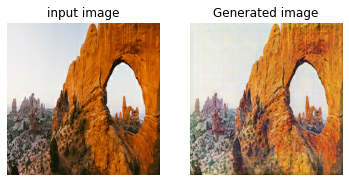

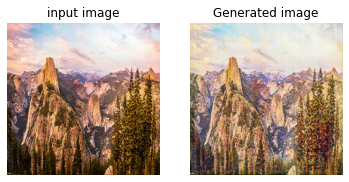

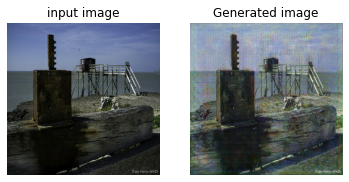

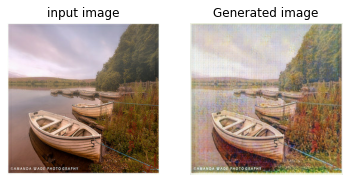

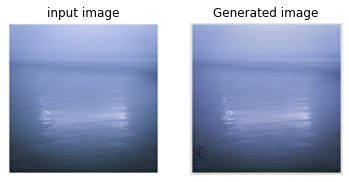

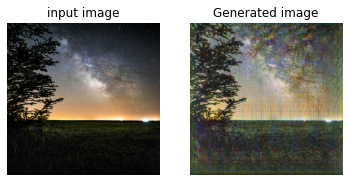

In [23]:
display_generated_samples(load_dataset(fn_photo).batch(8), monet_generator, 8)

In [24]:
os.makedirs('../images/')

predict_and_save(load_dataset(fn_photo).batch(1), monet_generator, '../images/')

In [25]:
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Generated samples: 7038
